<a href="https://colab.research.google.com/github/shayongithub/vnuk-ai-challenge1/blob/master/Challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
pwd

'/content/gdrive/MyDrive/VNUK-AI/Challenge 1'

In [2]:
cd gdrive/MyDrive/VNUK-AI/Challenge\ 1

/content/gdrive/MyDrive/VNUK-AI/Challenge 1


# **Load nessecary library**

In [5]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

# **Load the data into Google Collab**

In [12]:
eiffel_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/The%20Eiffel%20Tower.npy'
axe_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/axe.npy'
bicycle_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bicycle.npy'
golfclub_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/golf%20club.npy'
pizza_URL = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/pizza.npy'

_URL = [eiffel_URL, axe_URL, bicycle_URL, golfclub_URL, pizza_URL]
dir_name = ['The%20Eiffel%20Tower.npy', 'axe.npy', 'bicycle.npy', 'golf%20club.npy', 'pizza.npy']
ndjson_dir = []

for name, url in zip(dir_name,_URL):
    ndjson_dir.append(tf.keras.utils.get_file(name, cache_subdir='datasets/quickdraw',origin = url)) 

102219776/102210944 [==============================] - 1s 0us/step


In [8]:
eiffel = np.load(ndjson_dir[0])
axe = np.load(ndjson_dir[1])
bicycle = np.load(ndjson_dir[2])
golfclub = np.load(ndjson_dir[3])
pizza = np.load(ndjson_dir[4])

In [ ]:
eiffel[0].shape

(784,)

Merge all the data

In [34]:
max_items_per_class = 120000
num_val = 4000
# Declare the shape of X and y for training and testing
X = np.empty([0, 784])
y = np.empty([0])
# Declare the shape of X and y for validating
val_X = np.empty([0, 784])
val_y = np.empty([0])
# Load all the data
for i, file_path in enumerate(ndjson_dir):
    data = np.load(file_path)
    data_val = data[max_items_per_class:max_items_per_class+num_val, :]
    label_val = np.full(data_val.shape[0], i)

    data = data[0: max_items_per_class, :]
    labels = np.full(data.shape[0], i)

    X = np.concatenate((X, data), axis=0).astype('float32')#Convert to float32 to save memory
    y = np.append(y, labels)

    val_X = np.concatenate((val_X, data_val), axis = 0).astype('float32')
    val_y = np.append(val_y, label_val)

print(f'X shape: {X.shape}\ny shape: {y.shape}\nVal_X: {val_X.shape}\nVal_y: {val_y.shape}')

X shape: (600000, 784)
y shape: (600000,)
Val_X: (20000, 784)
Val_y: (20000,)


# **Examine the image**

In [20]:
def plot_samples(input_array, rows=4, cols=5, title=''):
    '''
    Function to plot 28x28 pixel drawings that are stored in a numpy array.
    Specify how many rows and cols of pictures to display (default 4x5).  
    If the array contains less images than subplots selected, surplus subplots remain empty.
    '''
    
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

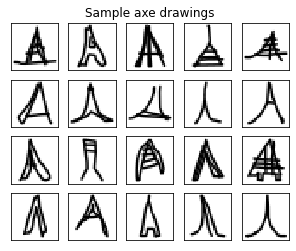

In [ ]:
plot_samples(eiffel, title = 'Sample axe drawings')

# **Preprocessing Data**

Splitting our data into train, test and validation set

In [50]:
#Reshape X and val_X into (28,28)
X = np.reshape(X, (X.shape[0], 28,28))
val_X = np.reshape(val_X, (val_X.shape[0], 28,28))

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X/255., y, test_size=0.3, random_state=42)

In [52]:
X_train.shape, y_train.shape

((420000, 28, 28), (420000,))

In [53]:
# Add a color dimension to the images in "train" and "validate" dataset to
# leverage Keras's data augmentation utilities later 
X_train = np.expand_dims(X_train, axis = 3)
X_test = np.expand_dims(X_test, axis = 3)

In [58]:
X_train[0].shape

(28, 28, 1)

# **Convolutional Neural Network (CNN)**

In [60]:
# one hot encode outputs
from keras.utils.np_utils import to_categorical
y_train_cnn = to_categorical(y_train)
y_test_cnn = to_categorical(y_test)
y_val_cnn = to_categorical(val_y)
num_classes = y_test_cnn.shape[1]

In [61]:
num_classes

5

In [62]:
X_train.shape

(420000, 28, 28, 1)

In [64]:
# reshape to be 
X_train_cnn = X_train.reshape(X_train.shape[0], 28, 28,1).astype('float32')
X_test_cnn = X_test.reshape(X_test.shape[0], 28, 28,1).astype('float32')
X_val_cnn = val_X.reshape(val_X.shape[0], 28, 28,1).astype('float32')

In [66]:
image_shape = X_train_cnn.shape[1:]
image_shape

(28, 28, 1)

## **Creating Model**

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(28,28,1)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

In [67]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(input_shape = image_shape, filters = 32, kernel_size=(5,5), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), activation='relu',padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2,2), strides=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer = adam_optimizer,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

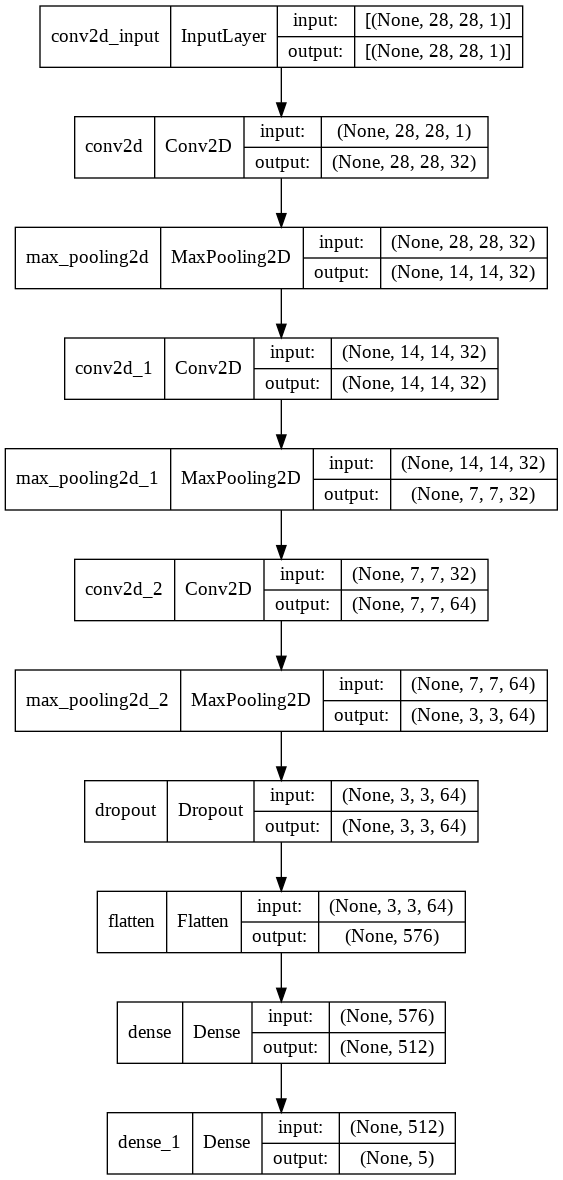

In [68]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

# **Run the model**

In [69]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy',
    restore_best_weights=True,
    verbose=1
)

In [70]:
%time 
epochs = 50
BATCH_SIZE = 2000
history = model.fit(X_train_cnn, y_train_cnn, 
                    validation_data=(X_test_cnn, y_test_cnn), 
                    epochs= epochs,
                    steps_per_epoch=int(np.ceil(X_train_cnn.shape[0] / float(BATCH_SIZE))), 
                    callbacks=[
                        early_stopping_callback
                    ],
                    verbose = 1)
model.save('saved_model/quickdraw.h5')
print('Model Save Successfully')

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11.7 µs
Epoch 1/50
  5/210 [..............................] - ETA: 7:30 - loss: 1.2904 - accuracy: 0.4677

KeyboardInterrupt: ignored

# Testing set accuracy

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)         

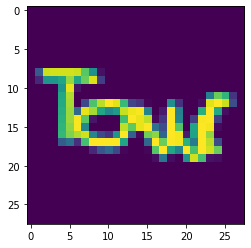

In [ ]:
plt.imshow(X_val_cnn[0])

In [ ]:
X_val_cnn[0].shape

(28, 28)

In [ ]:
y_proba = model.predict(X_val_cnn[0])
# y_classes = keras.np_utils.probas_to_classes(y_proba)

ValueError: ignored

In [ ]:
model = tf.keras.models.load_model('saved_model/quickdraw.h5')
train_loss, train_accuracy = model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

print('Train loss: ', '{:.2f}'.format(train_loss))
print('Train accuracy: ', '{:.2f}'.format(train_accuracy))

Train loss:  0.06
Train accuracy:  0.98


# Valditaion set accuracy

In [ ]:
val_loss, val_accuracy = model.evaluate(X_val_cnn, y_val_cnn, verbose=0)

print('Validation loss: ', '{:.2f}'.format(val_loss))
print('Validationain accuracy: ', '{:.2f}'.format(val_accuracy))

Validation loss:  15.31
Validationain accuracy:  0.98


# **Visualize training result**

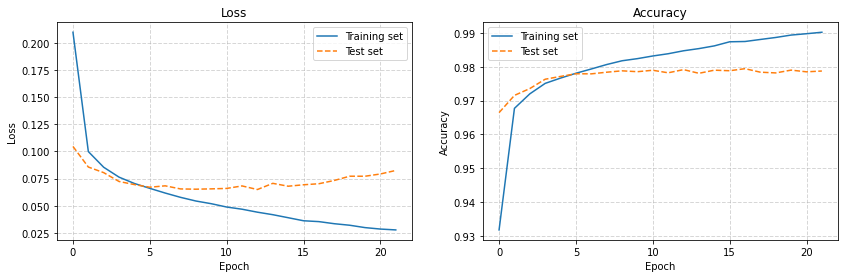

In [ ]:
# Renders the charts for training accuracy and loss.
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Test set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()
render_training_history(history)